<a href="https://colab.research.google.com/github/Lawrence-Krukrubo/fraud_analyst_assignment/blob/main/fraud_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# First let's mount Google Drive so we can navigate the folders as needed
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Let's import some much needed libraries...**

In [2]:
!pip install --upgrade --quiet pip
!pip install --quiet feature-engine
from feature_engine.outliers import Winsorizer
print('done!')

done!


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import xlrd
print('done!')

done!


**Let's change our Directory to the Fraud directory containing our data**

In [4]:
FRAUD_DIR = '/content/gdrive/MyDrive/Colab_Notebooks/fraud_analyst_assignment'
os.chdir(FRAUD_DIR)
print(f'Current Dir: {os.getcwd()}')

Current Dir: /content/gdrive/MyDrive/Colab_Notebooks/fraud_analyst_assignment


In [5]:
# Let's see the contents of the CWD
os.listdir()

['fraud_analysis.ipynb', 'Fraud_sample_data.xlsx', 'questionsAndPoints.gdoc']

The dataset contains 3 sheets, the first at index 0 is the data dictionary, the remaining two at indexes 1 and 2 are June and July transactions respectively.<br>**Let's read out the data dictionary to guide us**

In [6]:
pd.set_option('max_colwidth', None)  # So that we see full field descriptions
data_dict = pd.read_excel('Fraud_sample_data.xlsx', sheet_name=0)
data_dict

,Field name,Field description
0,merchant_id,Randomly generated identifier to represent a merchant
1,merchant_industry,Industry in which the merchant operates
2,merchant_category,Business category of the merchant
3,merchant_country,The country in which the merchant is based
4,currency,The local currency the transcation was processed in
5,transaction_week_start_date,Week in which the transaction occured
6,channel,The payment method for the transaction
7,transaction_count,The number of transactions for the day
8,transaction_volume_usd,The total value of the transactions converted to USD
9,fraud_count,The number of transactions which were reported as fraudulent for the day


**Now, let's read in the respective data for the months of June and July...**

In [7]:
# For June transactions
june_df = pd.read_excel('Fraud_sample_data.xlsx', sheet_name=1)

# For July transactions
july_df = pd.read_excel('Fraud_sample_data.xlsx', sheet_name=2)
print('done!')

done!


In [8]:
# Let's see the june and july data shapes
print(f'June data shape: {june_df.shape}\nJuly data shape: {july_df.shape}\n')

June data shape: (8609, 13)
July data shape: (8809, 13)



We can see that July transactions have more observations than June, precisely 200 more.<br>But they both have the same dimensions of 13 features. Let's see the head and tail of June.

In [9]:
june_df.head()

,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
0,1,GOODS-PHYSICAL,e-Commerce,Nigeria,NGN,2021-06-07,card,5,231.590551,0,NaN,0,5
1,5,SERVICES-LEGAL,Other,Nigeria,NGN,2021-06-07,card,2,210.203412,0,NaN,0,2
2,9,TRAVEL,Travel & Hospitality,Nigeria,NGN,2021-06-07,card,4,223.097113,0,NaN,0,1
3,11,SERVICES-PROFESSIONAL,Other,Nigeria,NGN,2021-06-07,card,5,212.335958,0,NaN,0,5
4,15,SERVICES-DIGITAL,Digital Services,Nigeria,NGN,2021-06-07,card,8,550.131234,0,NaN,0,8


In [10]:
june_df.tail()

,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
8604,8605,INTERNET,Utilities,Nigeria,NGN,2021-06-28,card,1,2.624672,0,NaN,0,1
8605,8606,GOODS-DIGITAL,Digital Services,Nigeria,NGN,2021-06-28,card,1,0.262467,0,NaN,0,1
8606,8607,SERVICES-DIGITAL,Digital Services,Nigeria,NGN,2021-06-28,card,3,15.748031,0,NaN,0,3
8607,8608,EVENTS,Travel & Hospitality,Nigeria,NGN,2021-06-28,card,2,0.656168,0,NaN,0,2
8608,8609,INTERNET,Utilities,Nigeria,NGN,2021-06-28,card,1,0.262467,0,NaN,0,1


**Let's see the head and tail of July**

In [11]:
july_df.head()

,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
0,1,GOODS-PHYSICAL,e-Commerce,Nigeria,NGN,2021-07-05,card,3,54.173228,0,NaN,0,3
1,5,SERVICES-LEGAL,Other,Nigeria,NGN,2021-07-05,card,4,486.712598,0,NaN,0,4
2,8,TRAVEL,Travel & Hospitality,Nigeria,NGN,2021-07-05,card,3,118.110236,0,NaN,0,0
3,9,SERVICES-PROFESSIONAL,Other,Nigeria,NGN,2021-07-05,card,4,151.968504,0,NaN,0,3
4,12,SERVICES-DIGITAL,Financial Services,Nigeria,NGN,2021-07-05,card,15,659.055118,0,NaN,0,12


In [12]:
july_df.tail()

,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
8804,8805,SERVICES-DIGITAL,Digital Services,Nigeria,NGN,2021-07-26,card,1,0.524934,0,NaN,0,1
8805,8806,SERVICES-DIGITAL,Digital Services,Nigeria,NGN,2021-07-26,card,1,0.259843,0,NaN,0,1
8806,8807,SERVICES-DIGITAL,Digital Services,Nigeria,NGN,2021-07-26,card,5,2.624672,0,NaN,0,5
8807,8808,RESTAURANTS,Travel & Hospitality,Nigeria,NGN,2021-07-26,card,2,1.049869,0,NaN,0,1
8808,8809,GOODS-PHYSICAL,e-Commerce,Nigeria,NGN,2021-07-26,card,1,1.312336,0,NaN,0,1


# Descriptive EDA (DA1):

**Descriptive analytics (DA1):** <br>is a preliminary stage of data processing that creates a summary of historical data to yield useful information and possibly prepare the data for further analysis. It is used largely to answer the question **[‘What happened?’]**. Querying, reporting, data aggregation, data mining and data visualization may be applied to yield more insight.

**Geo-Location-based DA1:**<br>
1. What is the distribution of transactions across the 3 countries?
2. What is the Fraud/Transactions Ratio per country?

**Fraud-related DA1:**<br>
3. What is the Max and Mean fraud value for June and July?
4. What is the total fraud recorded for June and July?
5. Drilling into OTP-Fraud, what’s the Max and Mean values monthly?
6. What is the Max and Mean dollar cost of fraud for June and July?
7. What is the ratio of fraudulent/non-fraudulent transactions monthly

Answering these questions, give us a top-level vision of the state of the transactions and fraudulent activities and their impacts across the 3 countries the business operates in.


### 1. Confirming the data-types

In [13]:
june_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8609 entries, 0 to 8608
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   merchant_id                  8609 non-null   int64         
 1   merchant_industry            8609 non-null   object        
 2   merchant_category            8609 non-null   object        
 3   merchant_country             8609 non-null   object        
 4   currency                     8609 non-null   object        
 5   transaction_week_start_date  8609 non-null   datetime64[ns]
 6   channel                      8609 non-null   object        
 7   transaction_count            8609 non-null   int64         
 8   transaction_volume_usd       8609 non-null   float64       
 9   fraud_count                  8609 non-null   int64         
 10  fraud_volume_usd             61 non-null     float64       
 11  otp_fraud                    8609 non-null 

In [14]:
july_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8809 entries, 0 to 8808
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   merchant_id                  8809 non-null   int64         
 1   merchant_industry            8809 non-null   object        
 2   merchant_category            8809 non-null   object        
 3   merchant_country             8809 non-null   object        
 4   currency                     8809 non-null   object        
 5   transaction_week_start_date  8809 non-null   datetime64[ns]
 6   channel                      8809 non-null   object        
 7   transaction_count            8809 non-null   int64         
 8   transaction_volume_usd       8809 non-null   float64       
 9   fraud_count                  8809 non-null   int64         
 10  fraud_volume_usd             51 non-null     float64       
 11  otp_fraud                    8809 non-null 

So, we can see the data-types for the months of June and July. They conform to the expected data-types. All columns that should be numeric are and all that should be categorical or object are too.

### 2. Checking the Descriptive Statistics of the data:

In [15]:
# For June numeric features

june_df.describe().T

,count,mean,std,min,25%,50%,75%,max
merchant_id,8609.0,4304.018469,2485.466539,1.000000,2153.000000,4304.000000,6456.000000,8.609000e+03
transaction_count,8609.0,485.230573,8253.372691,1.000000,1.000000,3.000000,11.000000,2.758660e+05
transaction_volume_usd,8609.0,7000.276672,73800.550994,0.000026,9.186352,43.307087,236.220472,2.396408e+06
fraud_count,8609.0,0.108375,3.175327,0.000000,0.000000,0.000000,0.000000,1.700000e+02
fraud_volume_usd,61.0,1858.473460,4641.861843,0.524934,26.246719,91.338583,539.212598,2.017848e+04
otp_fraud,8609.0,0.009293,0.265166,0.000000,0.000000,0.000000,0.000000,1.700000e+01
otp_all_transactions,8609.0,81.615402,589.620590,0.000000,1.000000,2.000000,9.000000,1.222300e+04


In [16]:
# For July numeric features

july_df.describe().T

,count,mean,std,min,25%,50%,75%,max
merchant_id,8809.0,4404.009536,2543.190394,1.000000,2201.000000,4405.000000,6607.000000,8.809000e+03
transaction_count,8809.0,452.862300,7493.961064,1.000000,1.000000,3.000000,12.000000,2.321840e+05
transaction_volume_usd,8809.0,6456.769974,65039.969627,0.000026,9.186352,43.307087,237.270341,2.444412e+06
fraud_count,8809.0,0.044386,1.144114,0.000000,0.000000,0.000000,0.000000,6.200000e+01
fraud_volume_usd,51.0,1261.399492,2420.278420,0.262467,21.900997,132.545932,1040.682415,9.956378e+03
otp_fraud,8809.0,0.006925,0.187173,0.000000,0.000000,0.000000,0.000000,1.000000e+01
otp_all_transactions,8809.0,156.574753,3732.010232,0.000000,1.000000,2.000000,9.000000,2.015910e+05


We can see that there's complete count for all numeric columns except `fraud_volume_usd` which has a count of 61 in June and 51 in July. This depicts missing values present. We can also observe the following...
1. Max `fraud_count` per day in June is 170, while in July is 62
2. Mean `fraud_volume_usd` in June is 1858, while in July is 1261. Note that these figures are large because we have only 61 and 51 data represented now, since the rest are NaN values in this column.
3. Max `fraud_volume_usd` in any given day in June is 20178, while July is 9956
4. For `otp_fraud`, the Max a day in June is 17, while July Max is 10
5. While June has Max `otp_all_transactions` a day as 12223 and July as 201591

**Let's see the count of unique merchants that did transactions for June and July**

In [17]:
june_merchant_count = june_df.merchant_id.nunique()
july_merchant_count = july_df.merchant_id.nunique()

print(f'Total Merchants for June: {june_merchant_count}\nTotal Merchants for July: {july_merchant_count}')

Total Merchants for June: 3866
Total Merchants for July: 3895


**So we had slightly more (about 29) merchants in July than June.**

In [18]:
# For June categoric features

june_df.describe(include='object').T

,count,unique,top,freq
merchant_industry,8609,63,GOODS-PHYSICAL,1358
merchant_category,8609,11,Digital Services,1601
merchant_country,8609,3,Nigeria,8577
currency,8609,4,NGN,8540
channel,8609,1,card,8609


In [19]:
# For July categoric features

july_df.describe(include='object').T

,count,unique,top,freq
merchant_industry,8809,62,GOODS-PHYSICAL,1356
merchant_category,8809,11,Other,1473
merchant_country,8809,3,Nigeria,8784
currency,8809,4,NGN,8744
channel,8809,1,card,8809


From the categorical features summary, we can see that...
1. There are 63 unique merchant industries in June and 62 in July,
2. There are 11 distinct merchant categories, and 3 distinct merchant countries, 4 distinct currencies and 1 distinct channel for both months, which is the `card` channel.

### 3. Checking for missing values:

In [20]:
june_df.isna().any()

merchant_id                    False
merchant_industry              False
merchant_category              False
merchant_country               False
currency                       False
transaction_week_start_date    False
channel                        False
transaction_count              False
transaction_volume_usd         False
fraud_count                    False
fraud_volume_usd                True
otp_fraud                      False
otp_all_transactions           False
dtype: bool

In [21]:
july_df.isna().any()

merchant_id                    False
merchant_industry              False
merchant_category              False
merchant_country               False
currency                       False
transaction_week_start_date    False
channel                        False
transaction_count              False
transaction_volume_usd         False
fraud_count                    False
fraud_volume_usd                True
otp_fraud                      False
otp_all_transactions           False
dtype: bool

We can see that for both June and July, only `fraud_volume_usd` has missing values. On further investigation, it is clear to see why. This is so because when `fraud_count` is 0, then `fraud_volume_usd` defaults to NaN.<br>Since we know that `fraud_volume_usd` should be 0, when `fraud_count` is 0, let's override this accordingly.

In [22]:
# replacing all missing values in the fraud_volume_usd col to 0

june_df.fraud_volume_usd.fillna(0, inplace=True)
july_df.fraud_volume_usd.fillna(0, inplace=True)
print('done!')

done!


**Let's confirm that all missing values have been replaced**

In [23]:
june_df.isna().any()

merchant_id                    False
merchant_industry              False
merchant_category              False
merchant_country               False
currency                       False
transaction_week_start_date    False
channel                        False
transaction_count              False
transaction_volume_usd         False
fraud_count                    False
fraud_volume_usd               False
otp_fraud                      False
otp_all_transactions           False
dtype: bool

In [24]:
july_df.isna().any()

merchant_id                    False
merchant_industry              False
merchant_category              False
merchant_country               False
currency                       False
transaction_week_start_date    False
channel                        False
transaction_count              False
transaction_volume_usd         False
fraud_count                    False
fraud_volume_usd               False
otp_fraud                      False
otp_all_transactions           False
dtype: bool

### 4. Some basic visualization of June and July transactions:

**Let's explore the distribution of transactions across the distinct countries for June and July**

In [25]:
def compare_pie_chart(sup_title, titles, s1, s2, size, colours):
    """Pie chart to compare values for June and July
    
    @param suptitle: Str, summary title of the plot
    @param titles: List of string sub-titles per plot
    @param s1: first series object
    @param s2: second series object
    @param size: A tuple of figure size
    @param colours: A List of colors for the piecharts
    """
    plt.figure(figsize=size)
    sns.set(font_scale=1.2)
    sns.set_style('ticks')
    plt.suptitle(sup_title, y=1.05)

    # For the first plot
    plt.subplot(121)
    plt.pie(s1, 
       autopct='%1.1f%%',
       colors=colours,
       startangle=90,
       shadow=True,
       pctdistance=1.06)
    plt.title(titles[0], y=1.05)
    plt.axis('equal')
    plt.legend(labels=s1.index, loc='upper right')

    # For the second plot
    plt.subplot(122)
    plt.pie(s2, 
       autopct='%1.1f%%',
       colors=colours,
       startangle=90,
       shadow=True,
       pctdistance=1.06)
    plt.title(titles[1], y=1.05)
    plt.axis('equal')
    plt.legend(labels=s2.index, loc='upper right')

    plt.show()

In [26]:
countries = list(june_df.merchant_country.unique())

def get_country_transactions(countries, df1, df2):
    """Function to get total transactions per country

    @param countries: list of string country names
    @param df1 and df2: June and July Dataframes
    """

    s1_list = []
    s2_list = []

    for country in countries:
        temp1 = df1[df1['merchant_country'] == country]
        s1_list.append(sum(temp1['transaction_count']))

        temp2 = df2[df2['merchant_country'] == country]
        s2_list.append(sum(temp2['transaction_count']))
    
    s1 = pd.Series(s1_list, index=countries)
    s2 = pd.Series(s2_list, index=countries)

    return s1, s2 

In [27]:
june_country_split, july_country_split = get_country_transactions(countries, june_df, july_df)

In [28]:
june_country_split

Nigeria         4177313
Ghana                35
South Africa          2
dtype: int64

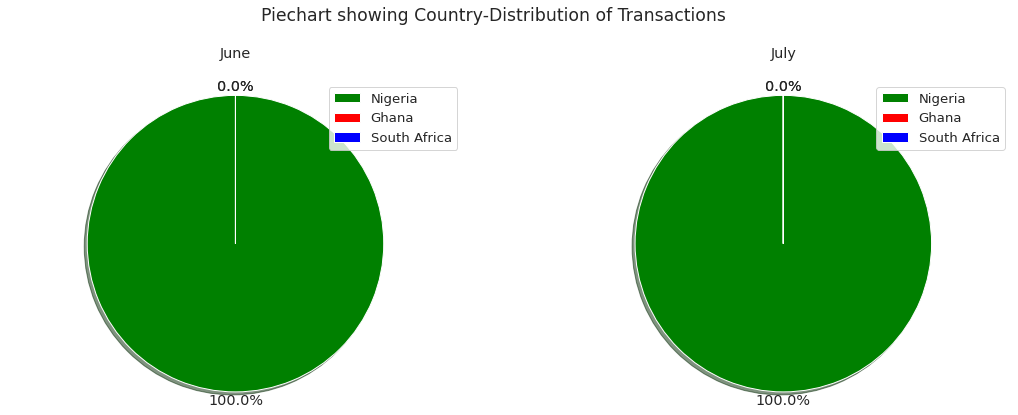

In [29]:
# Let's define some variables

sup_title = 'Piechart showing Country-Distribution of Transactions'
titles = ['June', 'July']
s1 = june_country_split
s2 = july_country_split
size = (18, 6)
colours = ['green','red','blue']

compare_pie_chart(sup_title, titles, s1, s2, size, colours)

In [30]:
ng_june_t = june_country_split['Nigeria']
ng_july_t = july_country_split['Nigeria']
gh_june_t = june_country_split['Ghana']
gh_july_t = july_country_split['Ghana']
sa_june_t = june_country_split['South Africa']
sa_july_t = july_country_split['South Africa']

print(f'In June, the country-transactions-count is:\nNigeria: {ng_june_t}\nGhana: {gh_june_t}\nSA: {sa_june_t}\n')
print()
print(f'In July, the country-transactions-count is:\nNigeria: {ng_july_t}\nGhana: {gh_july_t}\nSA: {sa_july_t}\n')

In June, the country-transactions-count is:
Nigeria: 4177313
Ghana: 35
SA: 2


In July, the country-transactions-count is:
Nigeria: 3989230
Ghana: 32
SA: 2



We can see from the three countries represented in the data, that Nigeria alone has over 99.7% of all transactions. Thus, I can assume that more fraudulent activities occur within Nigeria.<br>
* SA has only 2 transactions per month
* Ghana has just about 35 per month
* Nigeria has about 4 million transactions monthly.

**But before I jump to conclusions, let's see the percentage distribution of total fraud per country transactions.**

In [31]:
def get_country_fraud_pct_df(df):
    country_ratio = []

    for country in countries:
        country_df = df[df['merchant_country'] == country]
        ratio = sum(country_df.fraud_count) / sum(country_df.transaction_count)
        pct = ratio * 100
        country_ratio.append(pct)

    final_df = pd.DataFrame(country_ratio, index=countries, columns=['Pct'])

    return final_df

In [32]:
june_country_fraud_ratio = get_country_fraud_pct_df(june_df)
july_country_fraud_ratio = get_country_fraud_pct_df(july_df)

june_country_fraud_ratio

,Pct
Nigeria,0.022335
Ghana,0.000000
South Africa,0.000000


In [33]:
def compare_bar_chart(df1, df2, colours, col):
    plt.figure(figsize=size)
    sns.set(font_scale=1.2)
    sns.set_style('ticks')
    plt.suptitle(sup_title, y=1.05)

    # For June
    plt.subplot(121)
    plt.bar(x=df1.index, height=df1[col], data=df1, color= colours, width=0.5)
    plt.title(titles[0])
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    for x,y in zip(df1.index, df1[col]):
        label = round(y,2)  #  could also be written as:-   "{:.2f}".format(y)
        
        plt.annotate(label, # this is the text
                    (x,y), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,4), # distance from text to points (x,y)
                    ha='center',) # horizontal alignment can be left, right or center


    # For July
    plt.subplot(122)
    plt.bar(x=df2.index, height=df2[col], data=df2, color= colours, width=0.5)
    plt.title(titles[1])
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    for x,y in zip(df2.index, df2[col]):
        label = round(y,2) 
        plt.annotate(label,
                    (x,y), 
                    textcoords="offset points", 
                    xytext=(0,4),
                    ha='center',) 
    
    plt.show()

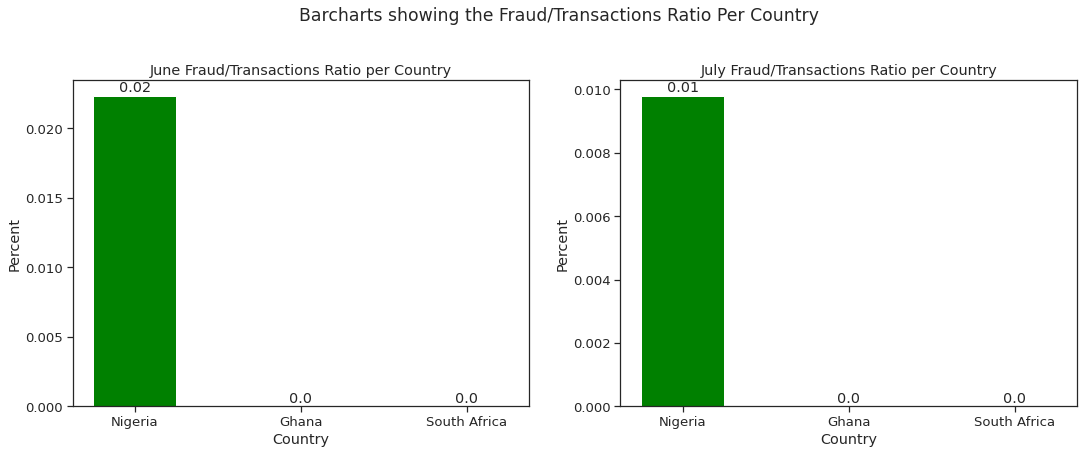

In [34]:
col='Pct'
sup_title = 'Barcharts showing the Fraud/Transactions Ratio Per Country'
titles = ['June Fraud/Transactions Ratio per Country', 'July Fraud/Transactions Ratio per Country']
labels = ['Country', 'Percent']

compare_bar_chart(june_country_fraud_ratio, july_country_fraud_ratio, colours, col)

Usually, only a small portion of transactions are fraudulent per organization.<br>This data shows us that...
1. Only Nigerian transactions recorded fraud
2. For June only 0.02% of transactions were flagged as fraud and only 0.01% in July
3. The data tends to depict that even with more transactions done in July, it had less fraud reports than in June.

**Let's visualize a few descriptive data values we deduced earlier**


In [35]:
indexs = ['max_fraud/Day', 'total_fraud/Month', 'max_otp_fraud/Day', 'ave_fraud_usd/Month','max_fraud_usd/Day']

june_data = [max(june_df.fraud_count), sum(june_df.fraud_count), max(june_df.otp_fraud), \
             june_df.fraud_volume_usd.mean(), max(june_df.fraud_volume_usd)]

july_data = [max(july_df.fraud_count), sum(july_df.fraud_count), max(july_df.otp_fraud), \
             july_df.fraud_volume_usd.mean(), max(july_df.fraud_volume_usd)]

In [36]:
def plot_clustered_bar(indexs, june_data, july_data):
    assert len(indexs) == len(june_data) == len(july_data)

    df = pd.DataFrame([june_data, july_data]).T
    df.index = indexs
    df.columns = ['June', 'July']
    #plt.xkcd()  # For xkcd style plots
    #plt.rcdefaults()  # to stop xkcd plots

    # your colors
    colors = ['#5bc0de', '#d9534f']

    # plot with annotations is probably easier
    p1 = df.plot(kind='bar', 
                 color=colors, 
                 figsize=(size), 
                 rot=0, 
                 ylabel='Count', 
                 title=title)

    plt.show()

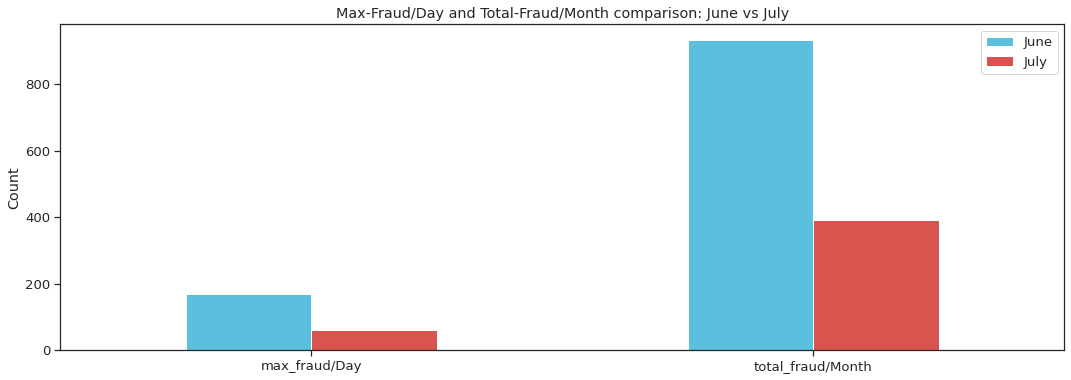

In [37]:
title = 'Max-Fraud/Day and Total-Fraud/Month comparison: June vs July'
plot_clustered_bar(indexs[:2], june_data[:2], july_data[:2])

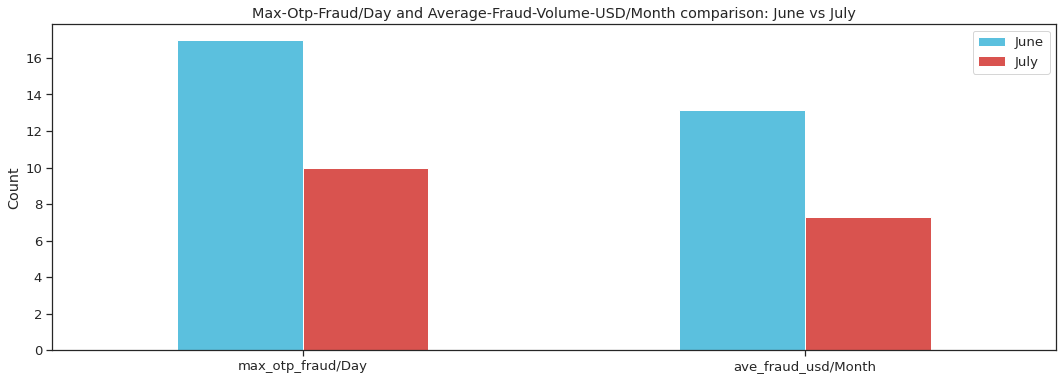

In [38]:
title = 'Max-Otp-Fraud/Day and Average-Fraud-Volume-USD/Month comparison: June vs July'
plot_clustered_bar(indexs[2:4], june_data[2:4], july_data[2:4])

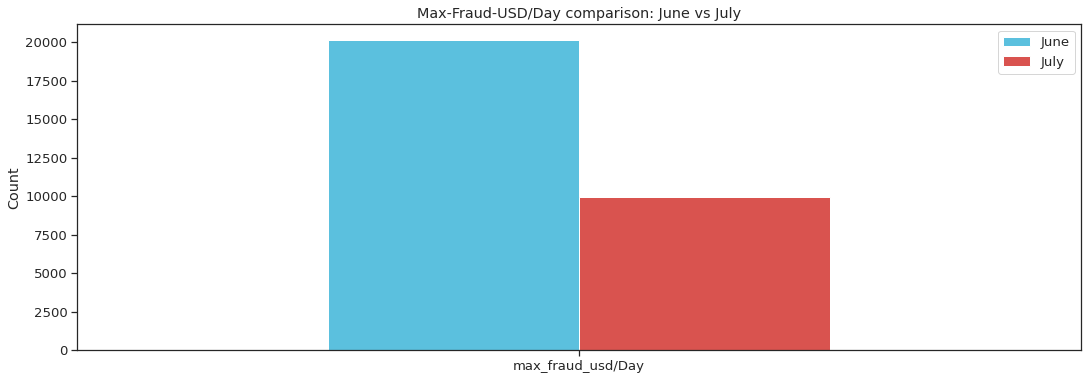

In [39]:
title = 'Max-Fraud-USD/Day comparison: June vs July'
plot_clustered_bar(indexs[4:], june_data[4:], july_data[4:])

# Diagnostic EDA (DA2):

**Diagnostic Analytics (DA2):**<br>
Diagnostic analytics are a deeper look at data to attempt to understand the causes of events and behaviours. It’s used largely to answer the question **[“Why did it happen?”]**, and is characterized by techniques such as : **drill-down** • **data discovery** • **data mining** • **correlations** • **mutual-information**

1. On a weekly basis, what weeks have the most Fraud?
2. Is there a correlation between weekly transactions count and fraud count?
3. Does fraud tend to increase due to social reasons like public holidays?
4. What Industries are most prone to Fraud?
5. What type of Merchants is most prone?
6. What features of the data are strongly related to fraud occurrences? We can try using Mutual-Information and correlation
7. What are the common patterns among merchants who record the most fraud? For example... What's the average transactions volume per week for high-risk merchants and others? Is there a correlation between fraud-count and transaction-count when compared to high-risk and other merchants?
8. Can we use clustering algorithms to learn any meaningful patterns or groupings that can help us learn more about the recent fraud spikes?

Asking and answering these questions give us a deeper understanding of the causes or patterns related to the spike in fraud.

### 5. Exploring Mutual-Information (MI) of variables:
Mutual information describes relationships in terms of uncertainty. The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

Mutual information is how many questions you expect the feature to answer about the target. It can help to understand the relative potential of a feature as a predictor of the target, considered by itself. But Mutual Information can't detect interactions between features, is a Univariate metric.

Finally, unlike Correlation that can only detect linear relationships, Mutual Information can detect all kinds and shapes of relations between features and target.

**First, let's combine both datasets**


In [40]:
combined_df = pd.concat([june_df, july_df])
combined_df.shape

(17418, 13)

**Since we joined two Dataframes with each having index from 0 to `len(df)-1`, let's fix the index of the combined-df**

In [41]:
new_index = list(range(len(combined_df)))
combined_df.index = new_index
print('done!')

done!


**Check for possible NaN values after combination**

In [42]:
combined_df.isna().any().sum()

0

In [43]:
combined_df.head()

,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
0,1,GOODS-PHYSICAL,e-Commerce,Nigeria,NGN,2021-06-07,card,5,231.590551,0,0.0,0,5
1,5,SERVICES-LEGAL,Other,Nigeria,NGN,2021-06-07,card,2,210.203412,0,0.0,0,2
2,9,TRAVEL,Travel & Hospitality,Nigeria,NGN,2021-06-07,card,4,223.097113,0,0.0,0,1
3,11,SERVICES-PROFESSIONAL,Other,Nigeria,NGN,2021-06-07,card,5,212.335958,0,0.0,0,5
4,15,SERVICES-DIGITAL,Digital Services,Nigeria,NGN,2021-06-07,card,8,550.131234,0,0.0,0,8


**Next, we make a copy of `combined_df` for mutual-information analysis.**

In [44]:
mi_combined = combined_df.copy(deep=True)
print('done!')

done!


In [45]:
# Next, pop the targets

target = mi_combined.pop('fraud_count')

In [46]:
# Next, get separate list for numeric and categoric columns

num_cols = list(mi_combined._get_numeric_data().columns)
cat_cols = list(set(mi_combined.columns) - set(num_cols))
print('done!')

done!


In [47]:
# Next, let's label-encode categorical variables

for colname in cat_cols:
    mi_combined[colname], _ = mi_combined[colname].factorize()
print('done!')

done!


**All categorical features should now have numerical datatypes**

In [48]:
mi_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17418 entries, 0 to 17417
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   merchant_id                  17418 non-null  int64  
 1   merchant_industry            17418 non-null  int64  
 2   merchant_category            17418 non-null  int64  
 3   merchant_country             17418 non-null  int64  
 4   currency                     17418 non-null  int64  
 5   transaction_week_start_date  17418 non-null  int64  
 6   channel                      17418 non-null  int64  
 7   transaction_count            17418 non-null  int64  
 8   transaction_volume_usd       17418 non-null  float64
 9   fraud_volume_usd             17418 non-null  float64
 10  otp_fraud                    17418 non-null  int64  
 11  otp_all_transactions         17418 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 1.7 MB


**Since our target `fraud_count` is a numerical feature, we shall use the mutual_info_regression method...**

In [49]:
# Next, identify discrete features

discrete_features = mi_combined.dtypes == int
print('done')

done


In [50]:
from sklearn.feature_selection import mutual_info_regression as mi

def make_mi_scores(X, y, discreteFeatures):
    mi_scores = mi(X, y, discrete_features=discreteFeatures)
    mi_scores = pd.Series(mi_scores, name='MI_scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    return mi_scores

**Now, let's get the Mutual Info scores for the combined data**

In [51]:
mi_scores = make_mi_scores(mi_combined, target, discrete_features)
print('done!')

done!


**Let's see a sample of the top scores**

In [52]:
mi_scores.head()

fraud_volume_usd          0.020932
transaction_volume_usd    0.018572
merchant_category         0.017529
otp_fraud                 0.012061
merchant_industry         0.010680
Name: MI_scores, dtype: float64

In [53]:
def plot_mi_scores(mi_scores):
    scores = mi_scores.sort_values(ascending=True)
    plt.figure(dpi=100, figsize=(8, 5))

    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

    plt.show()

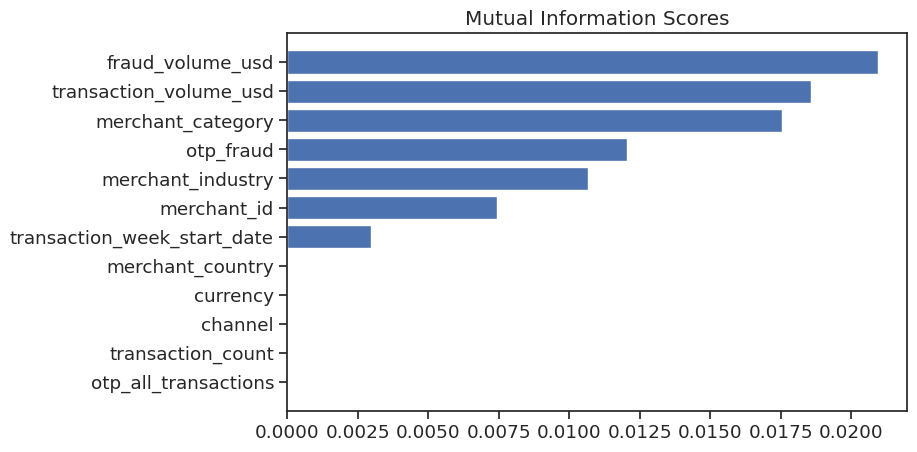

In [54]:
plot_mi_scores(mi_scores)

From the Mutual-Information analysis, we can see the features that are most discriminative to `fraud_count` . Therefore, we can proceed with our analysis focusing on these top features. Let's update the `mi_combined` dataframe to have only these features that tell us something about `fraud-count`.
 

### 6. Selecting Top MI-Scores features:

**Let's select the top features from MI analysis and ofcourse add the `fraud_count` column as our target. This can be used for any machine-learning task.**

In [55]:
# We'd use a threshold of 0.002 based on the MI chart above.
t = 0.002
top_mi = [ind for ind in list(mi_scores.index) if mi_scores[ind] >= t]

In [56]:
# Finally, append target column
top_mi.append('fraud_count')  

In [57]:
top_mi

['fraud_volume_usd',
 'transaction_volume_usd',
 'merchant_category',
 'otp_fraud',
 'merchant_industry',
 'merchant_id',
 'transaction_week_start_date',
 'fraud_count']

**Now, we re-create the `mi_combined` df but with only the features from MI-analysis**

In [58]:
# Now select only MI-features
mi_combined = combined_df[top_mi]

print(f'MI-combined shape is: {mi_combined.shape}\n')
mi_combined.head(3)

MI-combined shape is: (17418, 8)



,fraud_volume_usd,transaction_volume_usd,merchant_category,otp_fraud,merchant_industry,merchant_id,transaction_week_start_date,fraud_count
0,0.0,231.590551,e-Commerce,0,GOODS-PHYSICAL,1,2021-06-07,0
1,0.0,210.203412,Other,0,SERVICES-LEGAL,5,2021-06-07,0
2,0.0,223.097113,Travel & Hospitality,0,TRAVEL,9,2021-06-07,0


### 7. Analyzing Weekly Fraud Trends:
#### Trying to identify weeks where Fraud is high to check if there are possible social reasons for that.

In [59]:
june_weeks = list(june_df.transaction_week_start_date.unique())
july_weeks = list(july_df.transaction_week_start_date.unique())

# Let's add these together
june_weeks.extend(july_weeks)

# Let's rename the extension
weekly_dates = june_weeks

In [60]:
def get_weekly_fraud_and_transaction_counts(weeks_list, df_list, names=None):
    """Function to create Series of
        total fraud and transaction counts per-week
    
    @param weeks_list: A list of weeks start date,
    @param df_list: A list of one-combined or 2 split Dataframes,
    @param names: A list of String Series names, default=None,
    @return: Two Series objects
    """

    # if len(df_list) > 1, then combine into one df
    if len(df_list) > 1:
        df = pd.concat([df_list[0], df_list[1]])
        # arrange the index
        df.index = list(range(len(df)))
    else:
        df = df_list[0]

    june = 'June_W'
    july = 'July_W'
    indexs = []
    fraud_count = []
    trans_count = []
    i, j = 0, 0

    for week in weeks_list:
        temp_df = df[df['transaction_week_start_date'] == week]
        fraud_count.append(sum(temp_df.fraud_count))
        trans_count.append(sum(temp_df.transaction_count))
        if weeks_list.index(week) < 4:
            i+=1
            indexs.append(june + str(i))
        else:
            j+=1
            indexs.append(july + str(j))
            
    serie1 = pd.Series(fraud_count, index=indexs, name='Weekly Fraud Count')
    serie2 = pd.Series(trans_count, index=indexs, name='Weekly Transaction Count')

    if names:
        serie1.name = names[0]
        serie2.name = names[1]

    return serie1, serie2

In [61]:
weeks_list = weekly_dates
df_list = [june_df, july_df]

weekly_fraud_count, weekly_transact_count = get_weekly_fraud_and_transaction_counts(weeks_list, df_list)

In [62]:
weekly_fraud_count

June_W1    256
June_W2    284
June_W3    182
June_W4    211
July_W1    112
July_W2    109
July_W3     70
July_W4    100
Name: Weekly Fraud Count, dtype: int64

In [63]:
weekly_transact_count

June_W1     997735
June_W2    1064033
June_W3    1073565
June_W4    1042017
July_W1    1030233
July_W2     965332
July_W3     978273
July_W4    1015426
Name: Weekly Transaction Count, dtype: int64

Let's plot the weekly fraud trends...

In [64]:
def plot_weekly_trends(s1, s2, plot='bar'):
    """Method for plotting weekly fraud data
    """

    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'bold',
        'size': 16}

    plt.figure(figsize=(24,6))

    plt.subplot(1,2,1)
    plt.plot(s1)
    plt.xlabel('Week', fontdict=font)
    plt.ylabel('Count', fontdict=font)
    font['size'] = 20
    plt.title(s1.name, fontdict=font)

    if plot == 'bar':
        plt.subplot(1,2,2)
        plt.bar(x=s2.index, height=list(s2))
        plt.title(s2.name, fontdict=font)
        font['size'] = 16
        plt.xlabel('Week', fontdict=font)
        plt.ylabel('Count', fontdict=font)
    else:
        plt.subplot(1,2,2)
        plt.plot(s2, color='Red')
        plt.title(s2.name, fontdict=font)
        font['size'] = 16
        plt.xlabel('Week', fontdict=font)
        plt.ylabel('Count', fontdict=font)

    plt.show()

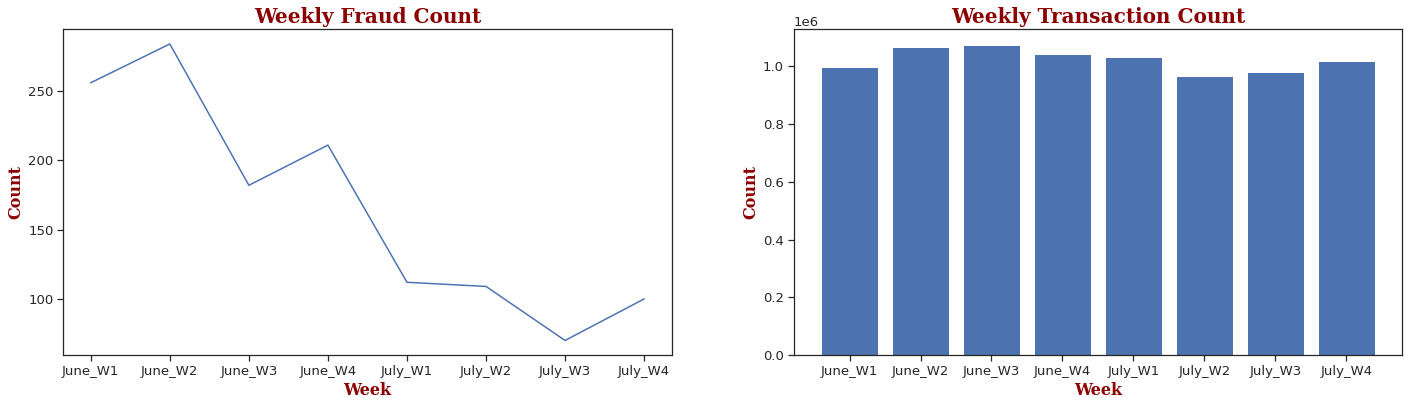

In [65]:
s1 = weekly_fraud_count
s2 = weekly_transact_count

plot_weekly_trends(s1, s2)

From the weekly fraud trend data, we can see that generally, fraud is trending downward. This does not mean it may not trend upward in the future, though, as can be seen in the rise in last week of July.

* Fraud starts high at about 250 for June-Wk-1
* It increases to about 280 for June-Wk-2
* Then it drops to about 180 in June-Wk-3
* Then it rises to about 210 in June-Wk-4
* And just keeps dropping weekly in July, lowest in July-Wk-3
* Starts rising again in July-Wk-4

While the weekly transactions count remain fairly constant between 970k and 1.07 million. Therefore, the data does not support the hypothesis that as fewer transactions are done, fewer fraud tends to be done. This is because the rate of fraud tends to decrease week by week, even though fairly same transactions are done. In otherwords, there's a weak correlation if any between weekly fraud count and weekly transactions count.

Although correlation does not imply cauation, we can see that:-   
* June 14th which marks the start of June-Wk-2 is a national holiday called **democracy-day** in Nigeria
* June 20th is Father's day
* June 23rd is also a regional holiday in Ebonyi State
* Tuesday July 20th and Wednesday July 21st are also public holidays called **id-el-kabir**

[source1](https://www.timeanddate.com/holidays/nigeria/), [source2](https://www.officeholidays.com/countries/nigeria/2021)

### 8. Drilling down on Fraudulent transactions data:

In [66]:
june_fraud_specific = june_df[june_df.fraud_count > 0]
print(f'June Fraud-Specific data shape is: {june_fraud_specific.shape}\n')

june_fraud_specific.head(3)

June Fraud-Specific data shape is: (61, 13)



,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
7,31,SAVINGS,Financial Services,Nigeria,NGN,2021-06-07,card,161803,1.840269e+06,2,0.787402,1,2247
26,114,CORPORATE,Other,Nigeria,NGN,2021-06-07,card,11317,2.271184e+05,1,5.511811,0,3063
34,147,BETTING,Betting,Nigeria,NGN,2021-06-07,card,16415,3.563845e+05,4,539.212598,3,2896


In [67]:
july_fraud_specific = july_df[july_df.fraud_count > 0]
print(f'July Fraud-Specific data shape is: {july_fraud_specific.shape}\n')

july_fraud_specific.head(3)

July Fraud-Specific data shape is: (51, 13)



,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
9,30,SAVINGS,Financial Services,Nigeria,NGN,2021-07-05,card,165099,1.822132e+06,10,1443.832021,1,2294
36,145,LENDING,Financial Services,Nigeria,NGN,2021-07-05,card,16172,3.501336e+05,1,2.650919,0,2786
128,486,BETTING,Betting,Nigeria,NGN,2021-07-05,card,232184,1.784707e+06,62,8424.934383,6,58841


**Let's see the distribution of fraud across `merchant_category` for June and July**

In [68]:
def selection(df, arr, empty_arr):
    """helper method for function below
    """
    for item in arr:
        temp = df[df[var] == item]
        empty_arr.append(sum(temp['fraud_count']))


def get_fraud_distribution_per_var(df1, df2, var, names, s=selection):
    """Function to derive fraud distribution per variable
        for both June and July datasets.

    @param df1 and df2; June and July Dataframes
    @param var: The specific categorical variable to split over
    @param names: A list of string titles for each Series
    @return: Two Series sorted descending
    """
    unique1 = list(df1[var].unique())
    unique2 = list(df2[var].unique())
    s1_list = []
    s2_list = []

    s(df1, unique1, s1_list)
    s(df2, unique2, s2_list)

    s1 = pd.Series(s1_list, index=unique1, name=names[0])
    s2 = pd.Series(s2_list, index=unique2, name=names[1])
    s1.sort_values(ascending=False, inplace=True)
    s2.sort_values(ascending=False, inplace=True)

    # compute percentages
    s1 = (s1 / sum(s1)) * 100
    s2 = (s2 / sum(s2)) * 100

    return s1, s2

In [69]:
df1 = june_fraud_specific
df2 = july_fraud_specific
var = 'merchant_category'
names = ['Merchant-Category Fraud: June', 'Merchant-Category Fraud: July']

june_merchant_cat_fraud, july_merchant_cat_fraud = get_fraud_distribution_per_var(df1, df2, var, names)
print('done!')

done!


In [70]:
june_merchant_cat_fraud

Betting                  80.814577
Financial Services       17.363344
Digital Services          0.643087
Other                     0.428725
Utilities                 0.321543
Media & Entertainment     0.214362
e-Commerce                0.107181
Education                 0.107181
Name: Merchant-Category Fraud: June, dtype: float64

In [71]:
july_merchant_cat_fraud

Financial Services      52.429668
Betting                 42.710997
e-Commerce               2.301790
Education                1.023018
Utilities                0.767263
Other                    0.511509
Travel & Hospitality     0.255754
Name: Merchant-Category Fraud: July, dtype: float64

**Let's visualize the top 5 merchant categories for fraudulent transactions**

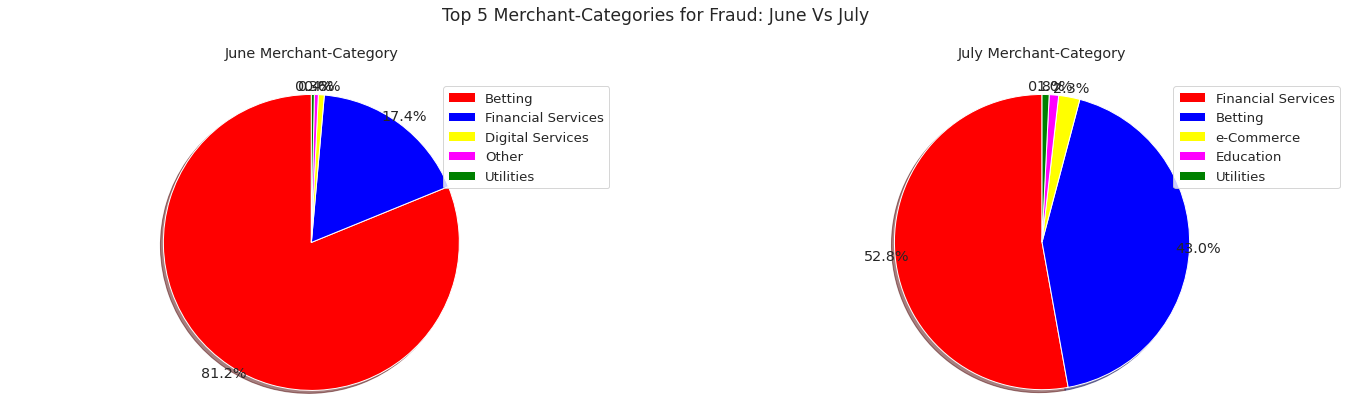

In [72]:
sup_title = 'Top 5 Merchant-Categories for Fraud: June Vs July'
titles = ['June Merchant-Category', 'July Merchant-Category']
s1 = june_merchant_cat_fraud[:5]
s2 = july_merchant_cat_fraud[:5]
colours = ['red', 'blue', 'yellow', 'magenta', 'green']
size = (24, 6)

compare_pie_chart(sup_title, titles, s1, s2, size, colours)

We can see that two merchant-categories make up more than 98% of total fraud. These are
1. Betting
2. Financial services

**Let's see the distribution of fraud across `merchant_industry` for June and July**

In [73]:
df1 = june_fraud_specific
df2 = july_fraud_specific
var = 'merchant_industry'
names = ['Merchant-Industry Fraud: June', 'Merchant-Industry Fraud: July']

june_merchant_ind_fraud, july_merchant_ind_fraud = get_fraud_distribution_per_var(df1, df2, var, names)
print('done!')

done!


In [74]:
june_merchant_ind_fraud

BETTING                 80.814577
LENDING                 16.077170
COOPERATIVES             0.857449
SERVICES-DIGITAL         0.643087
INTERNET                 0.321543
SAVINGS                  0.321543
NGO                      0.214362
SERVICES-PHYSICAL        0.107181
GOODS-PHYSICAL           0.107181
EDUCATION-VOCATIONAL     0.107181
RELIGIOUS                0.107181
REALESTATE               0.107181
REMITTANCE               0.107181
CORPORATE                0.107181
Name: Merchant-Industry Fraud: June, dtype: float64

In [75]:
july_merchant_ind_fraud

BETTING                  42.710997
LENDING                  40.153453
SAVINGS                   8.439898
GOODS-PHYSICAL            2.301790
INVESTMENT                2.301790
EDUCATION-SECONDARY       0.767263
REMITTANCE                0.511509
PSSP                      0.511509
TELECOMS                  0.511509
ASSOCIATION               0.255754
WALLETS                   0.255754
ELECTRICITY               0.255754
TRAVEL                    0.255754
COOPERATIVES              0.255754
EDUCATION-TERTIARY        0.255754
SERVICES-PROFESSIONAL     0.255754
Name: Merchant-Industry Fraud: July, dtype: float64

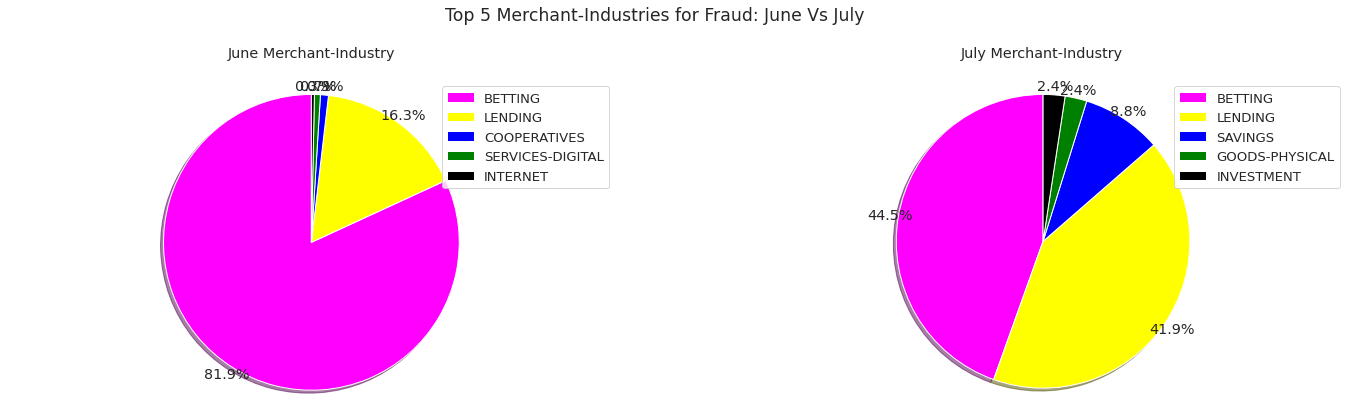

In [76]:
sup_title = 'Top 5 Merchant-Industries for Fraud: June Vs July'
titles = ['June Merchant-Industry', 'July Merchant-Industry']
s1 = june_merchant_ind_fraud[:5]
s2 = july_merchant_ind_fraud[:5]
colours = ['magenta', 'yellow', 'blue', 'green', 'black']
size = (24, 6)

compare_pie_chart(sup_title, titles, s1, s2, size, colours)

From the two sets of Piecharts above, we can surmise that...<br>
Merchants in the **Betting** and **Financial Services** category, who operate within the **Betting** and **Lending** industries recorded more than 98% of total frauds across merchant-categories and more than 96% of total fraud across merchant-industries, for the months of June and July 2021.

**The next step is to identify these merchants...**

So, we want to select merchants in the Betting and Financial-Services(FS) categories that operate within the Betting and Lending industries.

In [77]:
# First, we select Merchants whose category is either FS or Betting
high_risk = combined_df[(combined_df.merchant_category == 'Betting') \
                                    | (combined_df.merchant_category == 'Financial Services')]

# Then from these, we select those whose industries are BETTING or LENDING
high_risk = high_risk[(high_risk.merchant_industry == 'BETTING') \
                                              | (high_risk.merchant_industry == 'LENDING')]

# We do it this way, just incase BETTING and LENDING industries also exist in 
# other marchant-categories aside from Betting and Financial-Services.

print(f'Top-Concern-Merchants shape is: {high_risk.shape}\n', end=' ')
high_risk.head()

Top-Concern-Merchants shape is: (1521, 13)
 

,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
27,118,LENDING,Financial Services,Nigeria,NGN,2021-06-07,card,2511,30218.315853,0,0.000000,0,579
29,126,BETTING,Betting,Nigeria,NGN,2021-06-07,card,2,19.685039,0,0.000000,0,1
34,147,BETTING,Betting,Nigeria,NGN,2021-06-07,card,16415,356384.474199,4,539.212598,3,2896
37,158,LENDING,Financial Services,Nigeria,NGN,2021-06-07,card,1,0.026247,0,0.000000,0,1
50,216,BETTING,Betting,Nigeria,NGN,2021-06-07,card,81,1005.225696,0,0.000000,0,58


**Since we've identified them, let's also separate the others**

In [78]:
others_index = list(set(list(combined_df.index)) - set(list(high_risk.index)))
(len(others_index) + len(high_risk.index)) == len(combined_df.index)

True

In [79]:
others = combined_df.iloc[others_index, :]
print(len(others_index) == len(others))
print(f'others shape: {others.shape}\n')
others.head(3)

True
others shape: (15897, 13)



,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
0,1,GOODS-PHYSICAL,e-Commerce,Nigeria,NGN,2021-06-07,card,5,231.590551,0,0.0,0,5
1,5,SERVICES-LEGAL,Other,Nigeria,NGN,2021-06-07,card,2,210.203412,0,0.0,0,2
2,9,TRAVEL,Travel & Hospitality,Nigeria,NGN,2021-06-07,card,4,223.097113,0,0.0,0,1


**Let's see the actual split of distinct merchants in the High-Risk industries and other industries.**

In [80]:
num_high_risk_merchants = high_risk.merchant_id.nunique()
num_other_merchants = others.merchant_id.nunique()

print(f'High-Risk Merchants are: {num_high_risk_merchants}\nWhile others are {num_other_merchants} in total.')

High-Risk Merchants are: 500
While others are 5740 in total.


In [81]:
def plot_merchants_split(names, val1, val2, size, sup_title, color=colours):
    """Function to plot the split of merchants
        across High-Risk and low-Risk bounds.

    @param names: A list of string names
    @param val1 & val2: Integer values
    @param size: A tuple of figure size dimensions
    @param sup_title: String, the overall suptitle of both charts
    """

    plt.figure(figsize=size)

    fontDict ={'fontsize': 20,
        'fontweight' : 'bold',
        'verticalalignment': 'baseline',
      'color': 'Red',
       'family':'DejaVu Sans'}

    total = val1 + val2

    s1 = pd.Series([val1, val2], index=names, 
                       name='Count of High and Low Risk Merchants')
    s2 = pd.Series([(val1 / total)*100, (val2 / total)*100], index=names,
                       name='Percentage of High and Low Risk Merchants')
    
    plt.suptitle(sup_title, y=1.05, fontdict=fontDict)
    fontDict['fontsize'] = 14
    
    plt.subplot(1,2,1)
    plt.bar(x=s1.index, height=list(s1), color=colours)
    plt.xlabel('Merchant', fontdict=fontDict)
    plt.ylabel('Count', fontdict=fontDict)
    fontDict['fontsize'] = 18
    fontDict['color'] = 'Black'
    plt.title(s1.name, fontdict=fontDict)

    plt.subplot(1,2,2)
    plt.pie(s2, 
       autopct='%1.1f%%',
       startangle=90,
       colors=colours,
       shadow=True,
       pctdistance=1.06)
    plt.title(s2.name, fontdict=fontDict)
    plt.axis('equal')
    plt.legend(labels=s2.index, loc='upper right')
 
    plt.show()

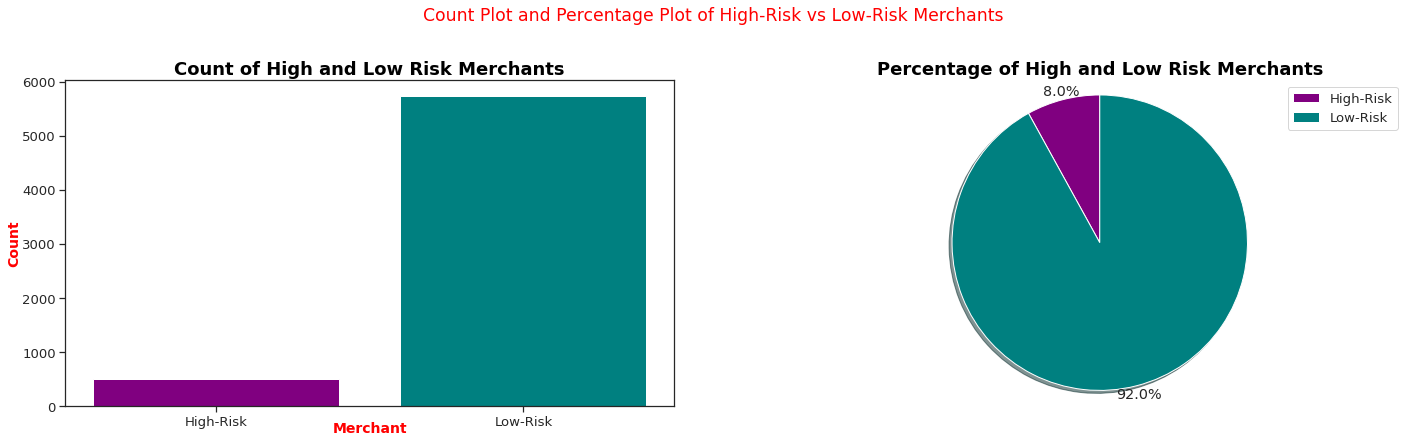

In [82]:
names = ['High-Risk', 'Low-Risk']
val1, val2 = num_high_risk_merchants, num_other_merchants
sup_title = 'Count Plot and Percentage Plot of High-Risk vs Low-Risk Merchants'
colours = ['Purple', 'Teal']

plot_merchants_split(names, val1, val2, size, sup_title)

From these charts, we can see that only 8% of Merchants constitute about 98% of fraud transactions. We need to take a much closer look at how these merchants conduct their day-to-day activities.

### 9. Finding Distinct Patterns of High-Risk Merchants

What are the common patterns among merchants who record the most fraud? For example: 
* What's the average transactions volume per week for high-risk merchants and others? 
* Is there a correlation between fraud-count and transaction-count when compared to high-risk and other merchants? 


**Let's see the descriptive statistics for these `top-concern` merchants**

In [83]:
# Let's see for Categorical Variables of top-concern merchants

high_risk.describe(include='object').T

,count,unique,top,freq
merchant_industry,1521,2,LENDING,973
merchant_category,1521,2,Financial Services,973
merchant_country,1521,1,Nigeria,1521
currency,1521,1,NGN,1521
channel,1521,1,card,1521


In [84]:
# Let's see for Categorical Variables of other merchants

others.describe(include='object').T

,count,unique,top,freq
merchant_industry,15897,61,GOODS-PHYSICAL,2714
merchant_category,15897,11,Digital Services,3035
merchant_country,15897,3,Nigeria,15840
currency,15897,4,NGN,15763
channel,15897,1,card,15897


In [85]:
# Let's see for Numerical Variables of top-concern merchants

high_risk.describe().T

,count,mean,std,min,25%,50%,75%,max
merchant_id,1521.0,4529.500329,2440.657734,65.000000,2520.000000,4571.000000,6835.000000,8.776000e+03
transaction_count,1521.0,3538.559500,23489.974503,1.000000,4.000000,26.000000,379.000000,2.758660e+05
transaction_volume_usd,1521.0,32272.061795,159843.601025,0.000131,19.181102,254.397559,3792.478163,2.271810e+06
fraud_count,1521.0,0.807364,7.982570,0.000000,0.000000,0.000000,0.000000,1.700000e+02
fraud_volume_usd,1521.0,102.467606,1082.253882,0.000000,0.000000,0.000000,0.000000,2.017848e+04
otp_fraud,1521.0,0.077581,0.733971,0.000000,0.000000,0.000000,0.000000,1.700000e+01
otp_all_transactions,1521.0,994.812623,9014.567615,0.000000,2.000000,17.000000,230.000000,2.015910e+05


In [86]:
# Let's see for Numerical Variables of other merchants

others.describe().T

,count,mean,std,min,25%,50%,75%,max
merchant_id,15897.0,4337.852740,2521.710303,1.000000,2156.000000,4340.000000,6489.000000,8.809000e+03
transaction_count,15897.0,175.156633,3775.687452,1.000000,1.000000,2.000000,9.000000,1.716440e+05
transaction_volume_usd,15897.0,4281.138742,52743.628819,0.000026,8.764698,39.370079,194.225722,2.444412e+06
fraud_count,15897.0,0.006039,0.192888,0.000000,0.000000,0.000000,0.000000,1.500000e+01
fraud_volume_usd,15897.0,1.374160,71.472388,0.000000,0.000000,0.000000,0.000000,6.430446e+03
otp_fraud,15897.0,0.001447,0.073966,0.000000,0.000000,0.000000,0.000000,8.000000e+00
otp_all_transactions,15897.0,35.779329,237.725621,0.000000,1.000000,2.000000,7.000000,6.980000e+03


From the describtive stats above, we can see that...
* High-Risk merchants on average performed 3538 transactions within these two months, whie other merchants did an average of 175 transactions.
* High-Risk merchants in the Betting and Lending business did an average of `$32k` USD for these two months. Others did an average of `$4.2k` USD.

* **What's the average transactions count per week for high-risk merchants and others?** 

In [87]:
high_risk.head(2)

,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
27,118,LENDING,Financial Services,Nigeria,NGN,2021-06-07,card,2511,30218.315853,0,0.0,0,579
29,126,BETTING,Betting,Nigeria,NGN,2021-06-07,card,2,19.685039,0,0.0,0,1


In [88]:
def find_ave_weekly_trans(df1, df2, dates):
    """Function to find the average transactions done weekly
    by high-risk and other merchants.

    @param df1 and df2: Dataframes for high-risk and other merchants
    @param col1 and col2: strings, column names to compute ratios
    @return: Dataframe of computed results
    """

    june = 'Jun_W'
    july = 'Jul_W'
    cols = ['High_Risk', 'Others']
    inds = []
    ave_trans = []
    i, j = 0, 0

    for date in dates:
        temp_list = []
        temp1 = df1[df1['transaction_week_start_date'] == date]
        temp2 = df2[df2['transaction_week_start_date'] == date]
        temp_list.append(temp1.transaction_count.mean())
        temp_list.append(temp2.transaction_count.mean())
        ave_trans.append(temp_list)
        if dates.index(date) < 4:
            i+=1
            inds.append(june+str(i))
        else:
            j+=1
            inds.append(july+str(j))
    
        ratio_df = pd.DataFrame(ave_trans, index=inds, columns=cols)
       
    return ratio_df

In [89]:
df1 = high_risk
df2 = others
dates = weekly_dates

ave_weekly_trans_df = find_ave_weekly_trans(df1, df2, dates)
ave_weekly_trans_df

,High_Risk,Others
Jun_W1,3559.687500,162.752460
Jun_W2,3976.813187,177.215104
Jun_W3,3685.256545,190.459042
Jun_W4,3392.797980,180.254625
Jul_W1,3720.910053,164.394671
Jul_W2,3303.219251,173.728136
Jul_W3,3351.684211,172.538151
Jul_W4,3341.026042,179.610471


In [90]:
print(f'On a weekly average, High-Risk merchants do {round(ave_weekly_trans_df.High_Risk.mean())}, while others do {round(ave_weekly_trans_df.Others.mean())} transactions.')

On a weekly average, High-Risk merchants do 3541, while others do 175 transactions.


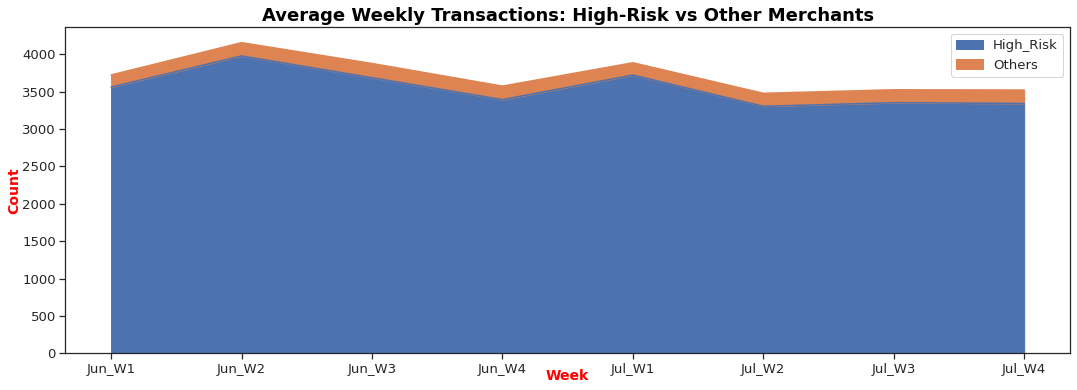

In [91]:
# First let's define a Font Dict
fontDict ={'fontsize': 18,
        'fontweight' : 'bold',
        'verticalalignment': 'baseline',
      'color': 'Black',
       'family':'DejaVu Sans'}

ave_weekly_trans_df.plot(kind='area', figsize=(18,6))
plt.title('Average Weekly Transactions: High-Risk vs Other Merchants', fontdict=fontDict)

fontDict['fontsize'] = 14
fontDict['color'] = 'Red'
plt.xlabel('Week', fontdict=fontDict)
plt.ylabel('Count', fontdict=fontDict)
plt.show()

**Observing weekly Fraud and Transactions trend for High-Risk Merchants.**

In [92]:
weeks_list = weekly_dates
df_list = [high_risk]
names = ['Weekly Fraud Count: High-Risk', 'Weekly Transaction Count: High-Risk']

weekly_fraud_count, weekly_transact_count = get_weekly_fraud_and_transaction_counts(weeks_list, df_list, names=names)

In [93]:
weekly_fraud_count

June_W1    246
June_W2    272
June_W3    180
June_W4    206
July_W1     92
July_W2     88
July_W3     53
July_W4     91
Name: Weekly Fraud Count: High-Risk, dtype: int64

In [94]:
weekly_transact_count

June_W1    683460
June_W2    723780
June_W3    703884
June_W4    671774
July_W1    703252
July_W2    617702
July_W3    636820
July_W4    641477
Name: Weekly Transaction Count: High-Risk, dtype: int64

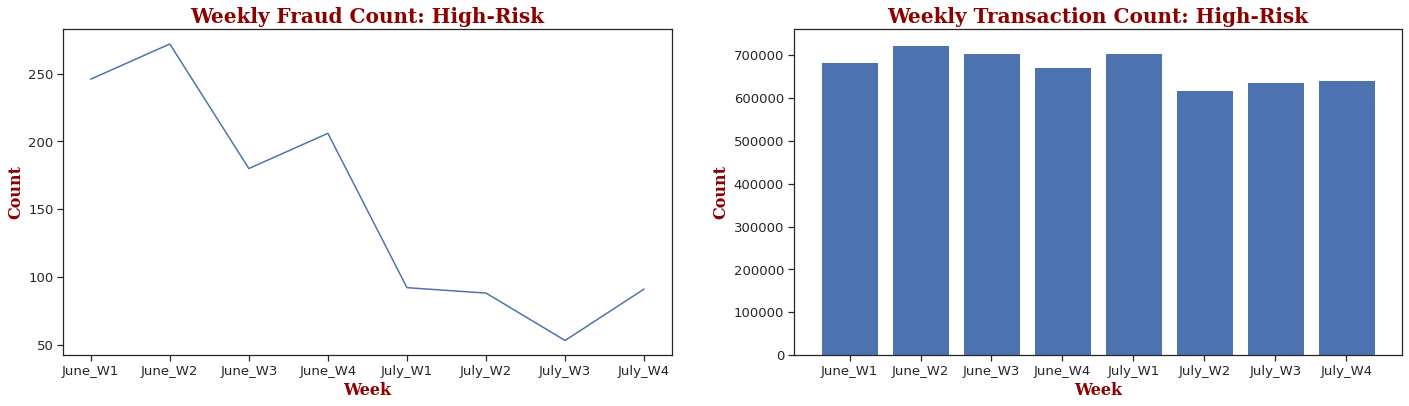

In [95]:
s1 = weekly_fraud_count
s2 = weekly_transact_count

plot_weekly_trends(s1, s2)

This relationship does not tell us anything distinct about the Top-Concern or High-Risk merchants, the weekly data looks very similar to the weekly trend for the entire data set.

The only distinct trait seen so far is that Merchants in the high-Risk industries of Betting and Lending perform a lot more transactions on average weekly, than regular merchants and record over 96% of all fraud attempts.

### 10. Feature-Engineering:

As we prepare to use our data for Machine-Learning activities, we need to prepare the data accordingly by performing certain activities


In [96]:
# First, make a copy of the mi_combined df

copy_mi = mi_combined.copy(deep=True)

In [97]:
def plot_hist(df,
              df_name,
              color=None,
              suptitle=None,
              size=(16,12),
             linewidth=1.5,
             edgecolor='black',
             density=True):
    
    num_cols = list(df.select_dtypes(include='number').columns)
    
    title = f'Numerical Values Distribution: {df_name}'
    if suptitle:
        title = df_name+': '+suptitle
        
    df[num_cols].hist(figsize=size,
                     linewidth=linewidth,
                     edgecolor=edgecolor,
                     color=color,
                     density=density)
    
    plt.suptitle(title, fontweight='bold', fontsize=16, y=0.95)
    plt.show()

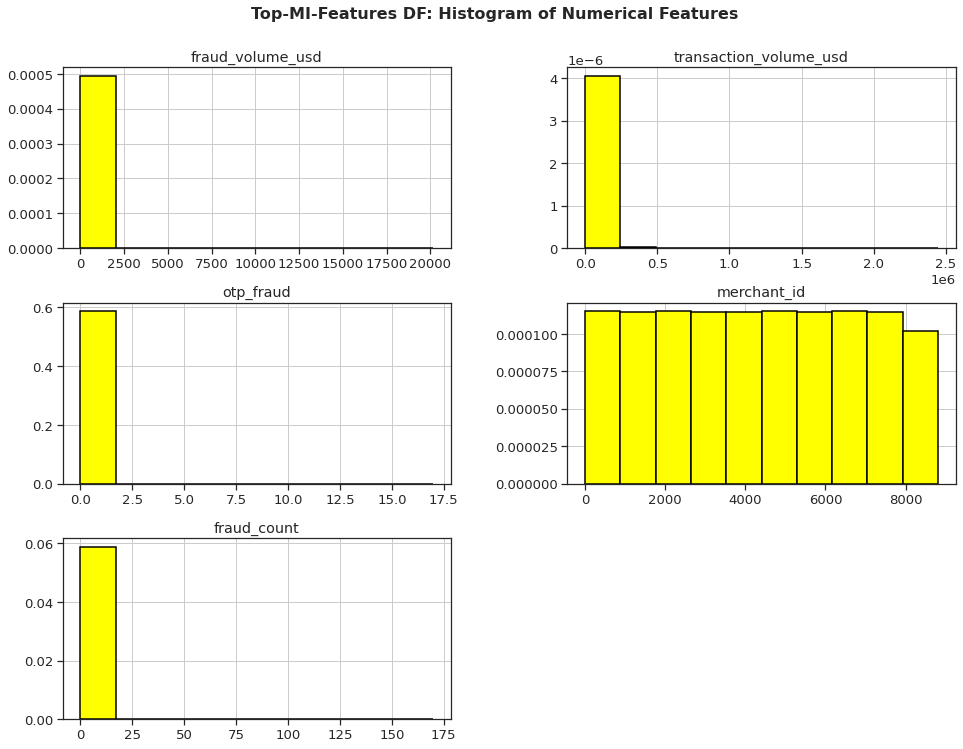

In [98]:
df_name = 'Top-MI-Features DF'
colour = 'yellow'
sup_title = 'Histogram of Numerical Features'

plot_hist(copy_mi, df_name, color=colour, suptitle=sup_title)

**Checking for outliers**

In [99]:
num_cols = list(copy_mi.select_dtypes(include='number').columns)
cat_cols = list(copy_mi.select_dtypes(exclude='number'))

In [100]:
def find_extreme_boundaries(variable, df, distance=3):
    """This method computes and returns the upper
        and lower outlier boundaries for each variable.
    """

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    if upper_boundary == lower_boundary:
        upper_boundary = max(df[variable])
        lower_boundary = min(df[variable])

    return upper_boundary, lower_boundary

**Let's see the extreme outliers in the numerical columns**

In [101]:
def extreme_outliers_toDF(df, cols):
    """This method computes the outliers
    in a dataframe and returns these values as a
    dataframe 

    @param df: A dataframe
    @param distance: The limit of outlier, max & default=3
    """
    outliers_dict = {}
    for col in cols:
        upper, lower = find_extreme_boundaries(col,df)
        outliers = np.where(df[col] > upper, True,
        np.where(df[col] < lower, True, False))
        count_outliers = np.sum(outliers)
        outliers_dict[col] = [count_outliers]
    
    outliers_df = pd.DataFrame(outliers_dict).T
    outliers_df.columns = ['count']
    return outliers_df

In [102]:
ext_outliers_df = extreme_outliers_toDF(copy_mi, num_cols)
ext_outliers_df

,count
fraud_volume_usd,0
transaction_volume_usd,2317
otp_fraud,0
merchant_id,0
fraud_count,0


**let's clip outliers to lower or max values**

In [103]:
def clip_extreme_outliers(main_df, sub_df):
    """Function clips extreme outliers

    @param df: a dataframe
    @param cols: list of columns to clip from
    """
    indx = list(sub_df.index)

    for ind in indx:
        if sub_df.at[ind, 'count'] > 100:
            high, low = find_extreme_boundaries(ind, main_df)
            print(ind,':', high, low)
            main_df[ind] = np.where(main_df[ind] > high, high,
                           np.where(main_df[ind] < low, low, main_df[ind]))
    return main_df

In [104]:
# Let's clip the extreme outliers
copy_mi = clip_extreme_outliers(copy_mi, ext_outliers_df)
print('done!')

transaction_volume_usd : 917.3228346456659 -671.9160104986852
done!


In [105]:
# Check for extreme outliers
extreme_outliers_toDF(copy_mi, num_cols)

,count
fraud_volume_usd,0
transaction_volume_usd,0
otp_fraud,0
merchant_id,0
fraud_count,0


**Normalizing Numeric data with Quantization and log-transform based on the shape of the distribution**

All aside from `merchant_id` will be normalized with log_transform

In [106]:
copy_mi.isna().any()

fraud_volume_usd               False
transaction_volume_usd         False
merchant_category              False
otp_fraud                      False
merchant_industry              False
merchant_id                    False
transaction_week_start_date    False
fraud_count                    False
dtype: bool

In [107]:
copy_mi.head()

,fraud_volume_usd,transaction_volume_usd,merchant_category,otp_fraud,merchant_industry,merchant_id,transaction_week_start_date,fraud_count
0,0.0,231.590551,e-Commerce,0,GOODS-PHYSICAL,1,2021-06-07,0
1,0.0,210.203412,Other,0,SERVICES-LEGAL,5,2021-06-07,0
2,0.0,223.097113,Travel & Hospitality,0,TRAVEL,9,2021-06-07,0
3,0.0,212.335958,Other,0,SERVICES-PROFESSIONAL,11,2021-06-07,0
4,0.0,550.131234,Digital Services,0,SERVICES-DIGITAL,15,2021-06-07,0


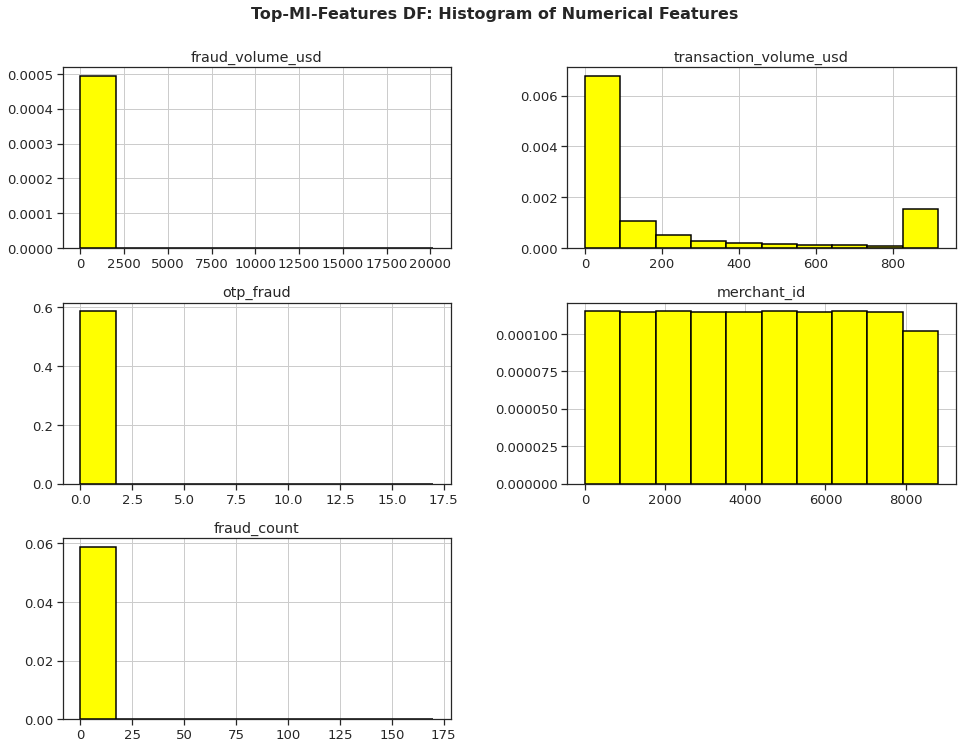

In [108]:
df_name = 'Top-MI-Features DF'
colour = 'yellow'
sup_title = 'Histogram of Numerical Features'

plot_hist(copy_mi, df_name, color=colour, suptitle=sup_title)

**From the data, we'd normalize `otp_all_transactions` and `transactions_volume_usd` and `merchant_id` with quantization, while the rest will be log-tranform** 

In [109]:
def log_transform(df, cols):
    for col in cols:
        data = df[col].astype('float').values
        # avoid division by zero issues
        data = np.log(data, out=data, where=data > 0.0000000001)
        df[col] = list(data)
    print('done!')

In [110]:
col_quant = ['otp_all_transactions', 'transaction_volume_usd', 'merchant_id']
col_log = [col for col in num_cols if col not in col_quant]

log_transform(copy_mi, col_log)

done!


In [111]:
copy_mi.isna().any()

fraud_volume_usd               False
transaction_volume_usd         False
merchant_category              False
otp_fraud                      False
merchant_industry              False
merchant_id                    False
transaction_week_start_date    False
fraud_count                    False
dtype: bool

In [112]:
numQuantiles = 20
colsQuantiles = col_quant

def createQuantiles(dfColumn, numQuantiles):
  return pd.qcut(dfColumn, numQuantiles, labels=False, duplicates='drop')


for string in colsQuantiles:
    if string in num_cols:
        copy_mi[string] = createQuantiles(copy_mi[string], numQuantiles)
print('done!')

done!


In [113]:
copy_mi.isna().any()

fraud_volume_usd               False
transaction_volume_usd         False
merchant_category              False
otp_fraud                      False
merchant_industry              False
merchant_id                    False
transaction_week_start_date    False
fraud_count                    False
dtype: bool

In [114]:
def minMaxScaler(numArr):
  minx = np.min(numArr)
  maxx = np.max(numArr)
  numArr = (numArr - minx) / (maxx - minx)
  return numArr

In [115]:
# Now, scale the numeric columns

for string in num_cols:
  copy_mi[string] = minMaxScaler(copy_mi[string])
print('done!')

done!


In [116]:
copy_mi.isna().any()

fraud_volume_usd               False
transaction_volume_usd         False
merchant_category              False
otp_fraud                      False
merchant_industry              False
merchant_id                    False
transaction_week_start_date    False
fraud_count                    False
dtype: bool

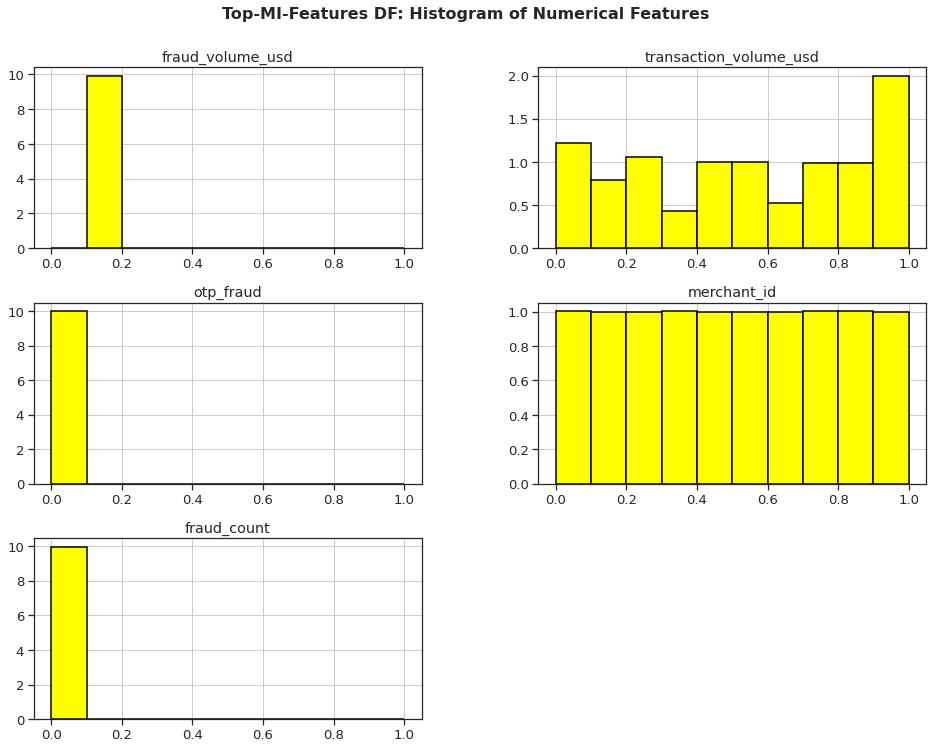

In [117]:
df_name = 'Top-MI-Features DF'
colour = 'yellow'
sup_title = 'Histogram of Numerical Features'

plot_hist(copy_mi, df_name, color=colour, suptitle=sup_title)

In [118]:
copy_mi.head()

,fraud_volume_usd,transaction_volume_usd,merchant_category,otp_fraud,merchant_industry,merchant_id,transaction_week_start_date,fraud_count
0,0.1189,0.823529,e-Commerce,0.0,GOODS-PHYSICAL,0.0,2021-06-07,0.0
1,0.1189,0.823529,Other,0.0,SERVICES-LEGAL,0.0,2021-06-07,0.0
2,0.1189,0.823529,Travel & Hospitality,0.0,TRAVEL,0.0,2021-06-07,0.0
3,0.1189,0.823529,Other,0.0,SERVICES-PROFESSIONAL,0.0,2021-06-07,0.0
4,0.1189,0.941176,Digital Services,0.0,SERVICES-DIGITAL,0.0,2021-06-07,0.0


**Encoding Categorical variables**

We may choose either to one-hot-encode these or merely discretize them numnerically using the factorize() function.

In [119]:
cat_cols = list(copy_mi.select_dtypes(exclude='number'))
cat_cols

['merchant_category', 'merchant_industry', 'transaction_week_start_date']

In [120]:
# Let's factorize and scale the categorical columns same time

for cat in cat_cols:
    copy_mi[cat], _ = copy_mi[cat].factorize()
    copy_mi[cat] = minMaxScaler(copy_mi[cat])
print('done!')

done!


In [121]:
copy_mi.isna().any()

fraud_volume_usd               False
transaction_volume_usd         False
merchant_category              False
otp_fraud                      False
merchant_industry              False
merchant_id                    False
transaction_week_start_date    False
fraud_count                    False
dtype: bool

In [122]:
copy_mi.head()

,fraud_volume_usd,transaction_volume_usd,merchant_category,otp_fraud,merchant_industry,merchant_id,transaction_week_start_date,fraud_count
0,0.1189,0.823529,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.1189,0.823529,0.1,0.0,0.016129,0.0,0.0,0.0
2,0.1189,0.823529,0.2,0.0,0.032258,0.0,0.0,0.0
3,0.1189,0.823529,0.1,0.0,0.048387,0.0,0.0,0.0
4,0.1189,0.941176,0.3,0.0,0.064516,0.0,0.0,0.0


### 10. Applying Clustering Machine Learning Algorithm

Centroid-based(CB) clustering are easier to use and interpret than density-based(DB) clustering. Although CB is susceptible to outliers and even clusters outliers, while DB is resistant to outliers. 

Therefore, let's check define some helper methods for K-means algorithm

In [123]:
import math
import numpy.linalg as nla
import altair as alt
import re
import pdb  # for Python debugger
import sys
from os.path import join

In [124]:
def dfSimilarity(df, centroids):
    """Calculate similarities for dataframe input.
        We use the Euclidean Distance calculation

    We need to calculate np.sqrt(||a-b||^2 = |a|^2 + |b|^2 - 2*|a|*|b|),
    and do so using matrix operations

    @param df: a dataframe, shape(m, n)
    @param centroids: subset of df, shape(k, n), 
                     where k is cluster size
    @return: An array of similarity scores
    """
    numPoints = len(df.index)
    numCentroids = len(centroids.index)

    ## Strictly speaking, we don't need to calculate the norm of points
    # because it adds a constant bias to distances
    # But calculating it so that the similarity doesn't go negative
    # And that we expect similarities in [0,1] which aids debugging

    # find the dot-product of each row or observation in df
    pointNorms = np.square(nla.norm(df, axis=1))
    # reshape the 1D array of dot-products to a column array
    pointNorms = np.reshape(pointNorms, [numPoints, 1])

    # # find the dot-product of each row or observation in centroids
    centroidNorms = np.square(nla.norm(centroids, axis=1))
    # reshape the 1D array of dot-products to a row array
    centroidNorms = np.reshape(centroidNorms, (1, numCentroids))

    ## Calculate |a|^2 + |b|^2 - 2*|a|*|b|
    similarities = pointNorms + centroidNorms - 2.0 * np.dot(
        df, np.transpose(centroids))
    
    # Divide by the number of feature directly if no OHE-features,
    # Else divide by original feature size if OHE
    similarities = similarities / df.shape[1]

    # numerical artifacts lead to negligible but negative values 
    # that go to NaN on the root, so let's clip such features
    similarities = similarities.clip(min=0.0)

    # Square root since it's ||a-b||^2
    similarities = np.sqrt(similarities)
    return similarities

In [125]:
def initCentroids(df, k, feature_cols):
    """Helper function to initialize centroids randomly

    @param df: a preprocesed dataframe for k-means
    @param k: An integer for number of clusters/centroids
    @param feature_cols: an array of string feature names for k-means
    @return: dataframe of centroids(sliced from df size(k, len(feature_cols)))
    """
    limit = len(df.index)
    centroids_key = np.random.randint(0, limit - 1, k)
    centroids = df.loc[centroids_key, feature_cols].copy(deep=True)
    # the indexes get copied over so reset them
    centroids.reset_index(drop=True, inplace=True)
    return centroids

In [126]:
def pt2centroid(df, centroids, feature_cols):
    """Helper function to calculate similarities between 
    all points and centroids, Assign points to the 
    closest centroids and save that distance.

    @param df: a dataframe, shape(m, n)
    @param centroids: subset of df, shape(k, n), 
                     where k is cluster size
    @param feature_cols: an array of string feature names for k-means
    @return: df with centroid and pt2centroid columns data
    """
    numCentroids = len(centroids.index)
    numExamples = len(df.index)

    # dfSimilarity = Calculate similarities for dataframe input
    dist = dfSimilarity(df.loc[:, feature_cols], centroids.loc[:, feature_cols])
    df.loc[:, 'centroid'] = np.argmin(dist, axis=1)  # closest centroid
    df.loc[:, 'pt2centroid'] = np.min(dist, axis=1)  # minimum distance
    return df

In [127]:
def recomputeCentroids(df, centroids, feature_cols):
    """Helper function to recompute centroids.
        Thus, for every centroid, recompute it as an
        average of the points assigned to it.

    @param df: a preprocesed dataframe for k-means
    @param feature_cols: an array of string feature names for k-means
    @param centroids: dataframe of centroids(sliced from df size(k, len(feature_cols)))
    """
  
    numCentroids = len(centroids.index)
    for cen in range(numCentroids):
        dfSubset = df.loc[df['centroid'] == cen,
                            feature_cols]  # all points for centroid
    if not (dfSubset.empty):  # if there are points assigned to the centroid
        clusterAvg = np.sum(dfSubset) / len(dfSubset.index)
        centroids.loc[cen] = clusterAvg
    return centroids

**Finally, we put all the helper functions together in the kmeans function below**

In [128]:
def kmeans(df, k, feature_cols, verbose, max_iter=100):
    flagConvergence = False
    maxIter = max_iter
    iter = 0  # initialize counter to 0

    centroids = initCentroids(df, k, feature_cols)
    while not (flagConvergence):
        iter += 1
        #Save old mapping of points to centroids
        oldMapping = df['centroid'].copy(deep=True)

        # Perform k-means
        df = pt2centroid(df, centroids, feature_cols)
        centroids = recomputeCentroids(df, centroids, feature_cols)

        # Check convergence by comparing [oldMapping, newMapping]
        newMapping = df['centroid']
        flagConvergence = all(oldMapping == newMapping)
        if verbose == 1:
            print('Total distance:' + str(np.sum(df['pt2centroid'])))
        if (iter > maxIter):
            print('k-means did not converge! Reached maximum iteration limit of ' \
                + str(maxIter) + '.')
            sys.exit()
            return
    print('k-means converged for ' + str(k) + ' clusters' + \
        ' after ' + str(iter) + ' iterations!')
    return df, centroids

**Let's now run K-means**

In [129]:
k = 30 
feature_cols = copy_mi.columns.values  # save original columns

# initialize every point to an impossible value, the k+1 cluster
copy_mi['centroid'] = k+1

# init the point to centroid distance to an impossible value "2" (>1)
copy_mi['pt2centroid'] = 2

# Let's see the new columns
copy_mi.head()

,fraud_volume_usd,transaction_volume_usd,merchant_category,otp_fraud,merchant_industry,merchant_id,transaction_week_start_date,fraud_count,centroid,pt2centroid
0,0.1189,0.823529,0.0,0.0,0.000000,0.0,0.0,0.0,31,2
1,0.1189,0.823529,0.1,0.0,0.016129,0.0,0.0,0.0,31,2
2,0.1189,0.823529,0.2,0.0,0.032258,0.0,0.0,0.0,31,2
3,0.1189,0.823529,0.1,0.0,0.048387,0.0,0.0,0.0,31,2
4,0.1189,0.941176,0.3,0.0,0.064516,0.0,0.0,0.0,31,2


In [130]:
# Run the K-means query
copy_mi, centroids = kmeans(copy_mi, k, feature_cols, verbose=1)

print("Data for the first few rows, with 'centroid' and 'pt2centroid' on"
      ' the extreme right:')
copy_mi.head()

Total distance:2261.585583241166
Total distance:2248.111258961716
Total distance:2227.0284125048574
Total distance:2208.199406318842
Total distance:2198.081369662184
Total distance:2192.430935746729
Total distance:2190.61492970732
Total distance:2189.789772853698
Total distance:2189.1792981835542
Total distance:2188.6623889720613
Total distance:2188.2298548130366
Total distance:2187.9532742937254
Total distance:2187.7104296563957
Total distance:2187.5790766322452
Total distance:2187.490364097678
Total distance:2187.436931873033
Total distance:2187.4084991831733
Total distance:2187.38944988581
Total distance:2187.383002889371
Total distance:2187.3736162518585
Total distance:2187.3578036085623
Total distance:2187.3466374491836
Total distance:2187.3411262981563
k-means converged for 30 clusters after 23 iterations!
Data for the first few rows, with 'centroid' and 'pt2centroid' on the extreme right:


,fraud_volume_usd,transaction_volume_usd,merchant_category,otp_fraud,merchant_industry,merchant_id,transaction_week_start_date,fraud_count,centroid,pt2centroid
0,0.1189,0.823529,0.0,0.0,0.000000,0.0,0.0,0.0,3,0.134618
1,0.1189,0.823529,0.1,0.0,0.016129,0.0,0.0,0.0,3,0.139300
2,0.1189,0.823529,0.2,0.0,0.032258,0.0,0.0,0.0,3,0.152486
3,0.1189,0.823529,0.1,0.0,0.048387,0.0,0.0,0.0,3,0.140231
4,0.1189,0.941176,0.3,0.0,0.064516,0.0,0.0,0.0,5,0.168039
